# Logistic Regression

Logistic regression problem taken from: Sören Laue, Matthias Mitterreiter, and Joachim Giesen. "GENO--GENeric Optimization for Classical Machine Learning." Advances in Neural Information Processing Systems 32 (2019). and https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

## Problem Description
Given a data matrix $X$ of dimension $n\times d$, and a label vector $y\in\{-1,+1\}^n$.

We have the following unconstrained optimization problem,

$$\min_{w \in R^{d}} ||w||_1 + C \sum_{i=1}^n \log(\exp(-y_i(X_i^Tw))+1), $$

where $C$ is the inverse of regularization parameter


## Modules Importing
Import all necessary modules and add PyGRANSO src folder to system path.

In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import l1_min_c
import sys
## Adding PyGRANSO directories. Should be modified by user
sys.path.append('/home/buyun/Documents/GitHub/PyGRANSO')
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
import torch

## Data Initialization 
Specify torch device, and generate data

Use GPU for this problem. If no cuda device available, please set *device = torch.device('cpu')*

In [2]:
device = torch.device('cuda')

iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y != 2]
y = y[y != 2]

X /= X.max()  # Normalize X to speed-up convergence

# Demo path functions
cs = l1_min_c(X, y, loss="log") * np.logspace(0, 7, 16)

X = torch.from_numpy(X).to(device=device, dtype=torch.double)
y = torch.from_numpy(y).to(device=device, dtype=torch.double)
[n,d] = X.shape
y = y.unsqueeze(1)

## Function Set-Up

Encode the optimization variables, and objective and constraint functions.

Note: please strictly follow the format of comb_fn, which will be used in the PyGRANSO main algortihm.

In [3]:
# variables and corresponding dimensions.
var_in = {"w": [d,1]}


def user_fn(X_struct,X,y,C):
    w = X_struct.w
    
    f = torch.sum(torch.log(torch.exp(-y* (X@w)) + 1))
    f+= torch.norm(w,p=1)/C

    # inequality constraint 
    ci = None

    # equality constraint
    ce = None

    return [f,ci,ce]

## User Options
Specify user-defined options for PyGRANSO

In [4]:
opts = pygransoStruct()
opts.torch_device = device
opts.maxit = 50
opts.opt_tol = 1e-6
np.random.seed(1)
opts.x0 = torch.zeros(d,1).to(device=device, dtype=torch.double)
opts.print_level = 0

## Main Algorithm

Computing regularization path ...
Problem 1 with C = 0.10007147962830593 completed
Problem 2 with C = 0.29307379488744323 completed
Problem 3 with C = 0.8583089764312021 completed
Problem 4 with C = 2.5136819185942896 completed
Problem 5 with C = 7.361680888087905 completed
Problem 6 with C = 21.55974671940413 completed
Problem 7 with C = 63.14083504447964 completed
Problem 8 with C = 184.917063358914 completed
Problem 9 with C = 541.5563525125441 completed
Problem 10 with C = 1586.0260682241312 completed
Problem 11 with C = 4644.906624058538 completed
Problem 12 with C = 13603.280537740799 completed
Problem 13 with C = 39839.17360792678 completed
Problem 14 with C = 116674.77924601595 completed
Problem 15 with C = 341698.95806769416 completed
Problem 16 with C = 1000714.7962830593 completed
This took 14.768s


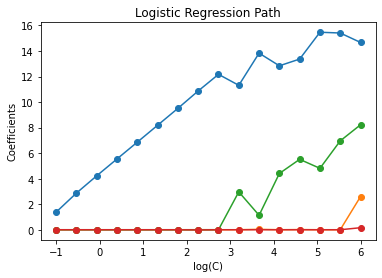

In [5]:
print("Computing regularization path ...")
start = time()
coefs_ = []
i = 0
for c in cs:
    i += 1
    comb_fn = lambda X_struct : user_fn(X_struct,X,y,c)
    torch.autograd.set_detect_anomaly(True)
    soln = pygranso(var_spec = var_in,combined_fn = comb_fn,user_opts = opts)
    print("Problem {} with C = {} completed".format(i,c))
    arr = soln.final.x.T.tolist()
    arr = np.array(arr).ravel()
    coefs_.append(arr)
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()